# LLMs: Beyond Chat

Large Language Models, like GPT-4o, are well known as capabale chatbots, through applications like ChatGPT and Copilot. While chatting with a computer is a magical experience, these models can do some much more than just chat. In this tutorial we'll review some of these capabilities and adopt an approach for working with LLMs that treats them more like an execution engine for software - a VM, if you will - than a chatty persona. We'll use structured input and ouput, relying on typed schema, to interface between the textual and difficult to predict and control world of LLMs and the realm of software development.

## Setting Up

### Installing Dependencies

We'll need the following Python packages:
- `openai` for making calls to Azure Open AI
- `pydantic` and `instructor` for using typed, structured input and output with our LLM calls
- `pydantic-settings` for loading the endpoint configuration from the .env file
- `pandas`, `matplotlib`, and `networkx` to help us visualise our output

In [1]:
%pip install openai==1.40.2 pydantic pydantic-settings pandas matplotlib networkx
from IPython.display import clear_output ; clear_output()

### Configuration

Copy the file `dot.env` to `.env`. Edit it and update the `OPENAI_API_KEY` if you are using OpenAI, or if you are using Azure Open AI, update the values for `AZURE_OPENAI_ENDPOINT`,`AZURE_OPENAI_API_KEY`, and `GPT_4_O_MODEL_NAME` (that's your deployment name).

The next cell will load these values and configure the OpenAI SDK to use them.

In [2]:
from pydantic_settings import BaseSettings, SettingsConfigDict
from pydantic import SecretStr
from pydantic import model_validator
from pprint import pprint

class Settings(BaseSettings):
    model_config = SettingsConfigDict(env_file='.env')

    OPENAI_API_KEY: SecretStr
    AZURE_OPENAI_ENDPOINT: str
    AZURE_OPENAI_API_KEY: SecretStr
    GPT_4_O_MODEL_NAME: str = 'gpt-4o-2024-08-06'

    @model_validator(mode='after')
    def validate_api_config(cls, values):
        if len(values.OPENAI_API_KEY) == 0 and len(values.AZURE_OPENAI_API_KEY) == 0:
            raise ValueError('API Key (either OPENAI_API_KEY or AZURE_OPENAI_API_KEY) is required')
        if len(values.AZURE_OPENAI_API_KEY) > 0:
            if len(values.AZURE_OPENAI_ENDPOINT) == 0:
                raise ValueError('AZURE_OPENAI_ENDPOINT is required when using Azure Open AI')
        if len(values.GPT_4_O_MODEL_NAME) == 0:
            values.GPT_4_O_MODEL_NAME = 'gpt-4o-2024-08-06'
        return values

    @property
    def is_azure(self):
        return (len(self.model_config.get('AZURE_OPENAI_ENDPOINT', '')) > 0 and
                len(self.model_config.get('AZURE_OPENAI_API_KEY', '')) > 0)

    def get_oai(self):
        if self.is_azure:
            from openai import AzureOpenAI
            return AzureOpenAI(
                api_version="2024-05-01-preview",
                azure_endpoint=self.AZURE_OPENAI_ENDPOINT,
                api_key=self.AZURE_OPENAI_API_KEY.get_secret_value(),
            )
        else:
            from openai import OpenAI
            return OpenAI(api_key=self.OPENAI_API_KEY.get_secret_value())

settings = Settings()

## Using Structured Input/Output with OpenAI

To use typed, structured input and output with our LLM calls, we will be relying on `pydantic` and `instructor`.

**Pydantic** ( [https://docs.pydantic.dev/](https://docs.pydantic.dev/) ) is a popular package for extending Python's typing system with declarative interfaces.

**Instructor** ( [https://python.useinstructor.com/](https://python.useinstructor.com/) ) patches the LLM SDK with the ability to use a Pydantic model for specifying the JSON schema for the LLM output, and parsing the result into the Pydantic mode. We will be using it in all of our examples to interact with our LLM.

Let's start by patching our LLM client and defining some helper functions...

In [3]:
from pydantic import BaseModel, Field
from openai import pydantic_function_tool
from typing import List
from enum import Enum
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

client = settings.get_oai()

# Let's define a helper function for calling the LLM. We will use this
# function for all our LLM calls.
def llm(response_model: BaseModel = BaseModel, system: str = None,
        user: str = None, temperature: float = 0.0, max_tokens: int = 1000):
    """
    Helper function for calling the LLM (GPT-4o) with a Pydantic BaseModel,
    a system prompt and/or a user prompt, with temperature and max_tokens.
    """
    messages = []
    if system:
        messages.append({"role": "system", "content": system})
    if user:
        messages.append({"role": "user", "content": user})
    result = client.beta.chat.completions.parse(
        model=settings.GPT_4_O_MODEL_NAME,
        messages=messages,
        response_format=response_model,
        temperature=temperature,
        max_tokens=max_tokens,
    )
    return result.choices[0].message.parsed

def print_schema(model: BaseModel):
    """
    Print the JSON schema corrsponding to a Pydantic model.
    """
    print(json.dumps(model.model_json_schema(), indent=2))

def print_result(result: BaseModel):
    """
    Print the Pydantic model result of an LLM call as JSON.
    """
    print(result.model_dump_json(indent=2))

# Configure Pandas to format dataframes for pretty output inside the notebook
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)
pd.DataFrame._repr_html_ = lambda df: df.style.set_properties(**{'text-align': 'left'})._repr_html_()

def visualize_graph(graph):
    """
    Visualize a graph.
    Expects a graph object with `nodes` and `edges` properties,
    where each node has an `id`, `label`, and `color`
    and each edge has `source`, `target`, `label`, and `color`.
    """
    G = nx.DiGraph()
    for node in graph.nodes:
        G.add_node(node.id, label=node.label, color=node.color)
    for edge in graph.edges:
        G.add_edge(edge.source, edge.target, label=edge.label, color=edge.color)
    pos = nx.planar_layout(G)
    node_colors = [node[1]['color'] for node in G.nodes(data=True)]
    edge_colors = [edge[2]['color'] for edge in G.edges(data=True)]
    labels = {node[0]: node[1]['label'] for node in G.nodes(data=True)}
    plt.figure(figsize=(7, 5))
    nx.draw(G, pos, labels=labels, with_labels=True, node_color=node_colors, edge_color=edge_colors, font_size=8)
    plt.title("Knowledge Graph")
    plt.show()

def print_tree(data, indent=0):
    """
    Pretty-print a JSON object as a tree.
    """
    if isinstance(data, dict):
        for key, value in data.items():
            print('   ' * indent + key.upper() + ':')
            print_tree(value, indent + 1)
    elif isinstance(data, list):
        for item in data:
            print_tree(item, indent)
    else:
        print('   ' * indent + str(data))

## Working with Text

LLMs are master text manipulators. If it's reading or writing text, the best LLMs can do amazing things.

### Translation and Normalization

Reading and writing, understanding and translating text between languages, or language styles, is an easy task with LLMs.

Let's start by reading a sentence in one language, detecting which language it is, and translating the sentence to English.

In [4]:
german_text = "Sprachkenntnisse sind ein wichtiger Bestandteil der Kommunikation."

class TranslatedString(BaseModel):
    input_language: str = Field(
        ...,
        description="The language of the original text, as 2-letter language code."
    )
    translation: str

translation = llm(
    TranslatedString,
    "Detect the language of the original text and translate it into English.",
    german_text,
)

print("RESULT:")
print_result(translation)

RESULT:
{
  "input_language": "de",
  "translation": "Language skills are an important part of communication."
}


Our LLM can cope with a more complex task. Let's get it to translate the same sentence to multiple languages.

Comment on token selection: for many processing tasks we'd want the LLM to be quite conservative with token selection, to get the most accurate results, but when it comes to writing text, it is often better to give it more freedom in selecting tokens from a wider distribution. We can control that by passing a higher `temperature` value when making the call.

In [7]:
english_text = "Large Language Models are a powerful tool for natural language processing."

class TargetLanguage(str, Enum):
    de = "de"
    fr = "fr"
    it = "it"
    es = "es"
    he = "he"

class Translation(BaseModel):
    language: TargetLanguage
    translation: str

class Translations(BaseModel):
    translations: List[Translation]

print_schema(Translations)

translations = llm(
    Translations,
    ("Translate the user-provided text into the following languages: " +
     json.dumps([language.value for language in TargetLanguage])),
    english_text,
    temperature=0.7,
)

pd.DataFrame(translations.dict()["translations"])

{
  "$defs": {
    "TargetLanguage": {
      "enum": [
        "de",
        "fr",
        "it",
        "es",
        "he"
      ],
      "title": "TargetLanguage",
      "type": "string"
    },
    "Translation": {
      "properties": {
        "language": {
          "$ref": "#/$defs/TargetLanguage"
        },
        "translation": {
          "title": "Translation",
          "type": "string"
        }
      },
      "required": [
        "language",
        "translation"
      ],
      "title": "Translation",
      "type": "object"
    }
  },
  "properties": {
    "translations": {
      "items": {
        "$ref": "#/$defs/Translation"
      },
      "title": "Translations",
      "type": "array"
    }
  },
  "required": [
    "translations"
  ],
  "title": "Translations",
  "type": "object"
}


,language,translation
0,TargetLanguage.de,Große Sprachmodelle sind ein leistungsstarkes Werkzeug für die Verarbeitung natürlicher Sprache.
1,TargetLanguage.fr,Les grands modèles de langage sont un outil puissant pour le traitement du langage naturel.
2,TargetLanguage.it,I modelli di linguaggio di grandi dimensioni sono uno strumento potente per l'elaborazione del linguaggio naturale.
3,TargetLanguage.es,Los modelos de lenguaje grandes son una herramienta poderosa para el procesamiento del lenguaje natural.
4,TargetLanguage.he,מודלים של שפה גדולה הם כלי חזק לעיבוד שפה טבעית.


Just as we can translate to different languages, we can also use the format to rewrite text in a different style or tone within the same language.

In [9]:
input_text = "Large Language Models are a powerful tool for natural language processing."

class TextStyle(str, Enum):
    formal = "formal"
    informal = "informal"
    casual = "casual"
    academic = "academic"
    professional = "professional"
    business = "business"

class NormalizedText(BaseModel):
    style: TextStyle
    text: str

class NormalizedTexts(BaseModel):
    normalized_texts: List[NormalizedText]

normalizations = llm(
    NormalizedTexts,
    ("Normalize the user-provided text into the following styles: " +
     json.dumps([style.value for style in TextStyle])),
    input_text,
    temperature=0.7,
)

pd.DataFrame(normalizations.dict()["normalized_texts"])

,style,text
0,TextStyle.formal,Large Language Models are an immensely powerful tool for the field of natural language processing.
1,TextStyle.informal,Large Language Models are super powerful for working with natural language processing.
2,TextStyle.casual,Large Language Models are really powerful when it comes to natural language processing.
3,TextStyle.academic,"Large Language Models constitute a significant advancement in the domain of natural language processing, offering robust capabilities and applications."
4,TextStyle.professional,Large Language Models represent a significant advancement in the capabilities of natural language processing technologies.
5,TextStyle.business,"Large Language Models provide a competitive edge in the realm of natural language processing, enhancing efficiency and effectiveness."


### Unstructured Data

One very powerful task we can use an LLM for, is parsing unstructured information into a data structure. Addresses, for example, are often found in documents in incosistent formats, and parsing them into a consistent data strcuture can be very useful for using them in a software system.

In [11]:
address_str = (
    "Sherlock Holmes lives in the United Kingdom. "
    "His residence is in at 221B Baker Street, London, NW1 6XE."
)

class AddressInfo(BaseModel):
    first_name: str
    last_name: str
    street: str
    house_number: str
    postal_code: str
    city: str
    state: str
    country: str

address_info = llm(
    AddressInfo,
    address_str,
)

print_result(address_info)

{
  "first_name": "Sherlock",
  "last_name": "Holmes",
  "street": "Baker Street",
  "house_number": "221B",
  "postal_code": "NW1 6XE",
  "city": "London",
  "state": "",
  "country": "United Kingdom"
}


That was easy! We didn't even have to prompt, just let the LLM know what is the data structure we are expecting. How about a more complex input with multiple addresses? We should be able to get the LLM to process that too.

In [12]:
input_text = (
  "During my recent travels, I had the pleasure of visiting several fascinating locations. "
  "My journey began at the office of Dr. Elena Martinez, 142B Elm Street, San Francisco, "
  "CA 94107, USA. Her office, nestled in the bustling heart of the city, was a hub of "
  "innovation and creativity. Next, I made my way to the historic residence of Mr. Hans "
  "Gruber located at 3. Stock, Goethestrasse 22, 8001 Zürich, Switzerland. The old building, "
  "with its classic Swiss architecture, stood as a testament to the city’s rich cultural "
  "heritage. My adventure continued at the tranquil countryside home of Satoshi Nakamoto, "
  "2-15-5, Sakura-cho, Musashino-shi, Tokyo-to 180-0003, Japan. Their home was surrounded by "
  "beautiful cherry blossoms, creating a picturesque scene straight out of a postcard. In "
  "Europe, I visited the charming villa of Mme. Catherine Dubois, 15 Rue de la République, "
  "69002 Lyon, France. The cobblestone streets and historic buildings of Lyon provided a "
  "perfect backdrop to her elegant home. Finally, my journey concluded at the modern apartment "
  "of Mr. David Johnson, Apt 7B, 34 Queen Street, Toronto, ON M5H 2Y4, Canada. The sleek "
  "design of the apartment building mirrored the contemporary vibe of the city itself."
  )

class Addresses(BaseModel):
    addresses: List[AddressInfo]

addresses_in_text = llm(
    Addresses,
    "Return all the addresses in the user-provided text.",
    input_text,
)

pd.DataFrame(addresses_in_text.dict()["addresses"])

,first_name,last_name,street,house_number,postal_code,city,state,country
0,Elena,Martinez,Elm Street,142B,94107,San Francisco,CA,USA
1,Hans,Gruber,Goethestrasse,22,8001,Zürich,,Switzerland
2,Satoshi,Nakamoto,Sakura-cho,2-15-5,180-0003,Musashino-shi,Tokyo-to,Japan
3,Catherine,Dubois,Rue de la République,15,69002,Lyon,,France
4,David,Johnson,Queen Street,34,M5H 2Y4,Toronto,ON,Canada


The intelligence of LLMs allows them to "understand" complex logical and hierarchical structures. Consider the task of converting some information into a knowledge graph. Turning longform text into structure we can work with as part of a system can be of great value, and our LLM can help us achieve that.

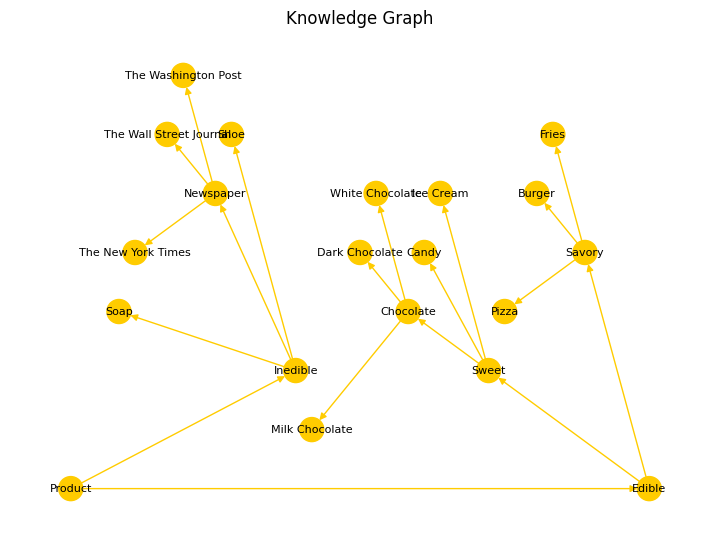

In [15]:
input_text = (
    "Some products are edible and others are inedible. Soap, newspapers, and shoes, for example, "
    "are inedible. Of the products that are edible, some are sweet and others are savory. "
    "Chocolate, candy, and ice cream are sweet, while pizza, burgers, and fries are savory. "
    "Chocolate comes in different forms, such as milk chocolate, dark chocolate, and white chocolate. "
    "The New York Times, The Wall Street Journal, and The Washington Post are newspapers."
)

class Node(BaseModel):
    id: int
    label: str
    color: str

class Edge(BaseModel):
    source: int
    target: int
    label: str
    color: str

class KnowledgeGraph(BaseModel):
    nodes: List[Node]
    edges: List[Edge]

knowledge_graph = llm(
    KnowledgeGraph,
    "Format the information in the user-provided text as a knowledge graph.",
    input_text,
)

visualize_graph(knowledge_graph)


Some structures are recursive. Consider the task of parsing a linguistic sentence into a grammatical tree structure. This NLP task has kept computational linguists busy for decades, often with limited success. LLMs, however, are quite good at this sort of thing. Let's try to get the LLM to parse a simple sentence into a simplified tree grammar of English.

In [16]:
input_str = "the quick brown fox jumps over the lazy dog"

class NounPhrase(BaseModel):
    det: str
    adj: List[str]
    noun: str

class PrepPhrase(BaseModel):
    prep: str
    noun: NounPhrase

class VerbPhrase(BaseModel):
    noun: NounPhrase
    verb: str
    prep: PrepPhrase

grammar_tree = llm(
    VerbPhrase,
    "Parse the user-provided sentence into a simple grammar tree.",
    input_str,
)

print_tree(grammar_tree.dict())


NOUN:
   DET:
      the
   ADJ:
      quick
      brown
   NOUN:
      fox
VERB:
   jumps
PREP:
   PREP:
      over
   NOUN:
      DET:
         the
      ADJ:
         lazy
      NOUN:
         dog


💡 What other cases do you know where parsing unstructured information from text into data structures is a useful application? Could you automate any process that is currently performed manually by giving the task to an LLM? ... Some models (like GPT-4o) can also read images as input ... how about using a photo or scan as the input and parsing it into structured data?

## Synthetic Data Generation

They used to say that "data is the new oil". That valuable! What if we found an endless supply of data to work with? LLMs are great at generating new texts and pieces of information. That can be very useful in many data science and ML projects, as we can use the LLM to generate synthetic data for us.

Let's try using the LLM to generate some test data for exercising a sentiment analysis system.

In [17]:
class SyntheticSentiment(BaseModel):
    sentiment: str = Field(..., description="A review about food.")
    rating: int

sentiment = llm(
    SyntheticSentiment,
    "Generate food review with sentiments within a spectrum of sentiments, with rating between 1 and 5.",
    temperature= 0.5
)

print_result(sentiment)

{
  "sentiment": "I recently visited \"The Rustic Spoon\" and ordered their signature dish, the Truffle Mushroom Pasta. The presentation was quite appealing, with a generous amount of mushrooms topped with a drizzle of truffle oil. However, the taste did not live up to its visual appeal. The pasta was slightly overcooked, resulting in a mushy texture that detracted from the overall experience. The truffle flavor was too subtle, almost overshadowed by the cream sauce, which was overly rich and heavy. On a positive note, the portion size was generous, and the service was prompt and friendly. Unfortunately, the dish did not meet my expectations, leaving me somewhat disappointed.",
  "rating": 2
}


That's easy. Now let's generate multiple examples.

In [18]:
class Rating(str, Enum):
    poor = "*"
    average = "**"
    good = "***"
    great = "****"
    outstanding = "*****"

class SyntheticSentiment(BaseModel):
    sentiment: str = Field(..., description="A generated review about food.")
    rating: str = Field(...,description="rating of food review between 1 and 5")

class SyntheticSentiments(BaseModel):
    sentiments: List[SyntheticSentiment]

n = 10

sentiments = llm(
    SyntheticSentiments,
    (f"Generate {n} food review with sentiments within a spectrum of sentiments in " + 
     "sorted order from most negative to positive, with rating: " +
     json.dumps([rating for rating in Rating])),
    temperature=0.7,
)

pd.DataFrame(sentiments.dict()["sentiments"])

,sentiment,rating
0,"The pasta was overcooked, the sauce was bland, and overall it was a disappointing meal. I wouldn't recommend it to anyone.",*
1,"The soup was too salty, and the bread was stale. I expected much better from this restaurant.",**
2,"The pizza was okay, but nothing special. The crust was a bit soggy, and the toppings were sparse.",**
3,"The burger was decent, but the fries were cold by the time they got to the table. It wasn't the best experience.",***
4,"The salad was fresh and the dressing was tasty, but the portion was a bit small for the price.",***
5,"The sandwich was quite good, with fresh ingredients and a nice balance of flavors. I enjoyed it.",****
6,The steak was cooked perfectly and the sides complemented it well. A satisfying meal overall.,****
7,"The sushi was fresh and delicious, with a great variety of rolls to choose from. I would definitely come back.",*****
8,"The dessert was absolutely delightful, with rich flavors and a beautiful presentation. A perfect ending to the meal.",*****
9,"The entire dining experience was fantastic, from the attentive service to the exquisite dishes. Highly recommend!",*****


💡 Where can you use unlimited amount of test data, conforming to strict ranges and structures? What projects or tests can you run if collecting a data set is as trivial as calling an LLM?

## Decision Making

We've looked at LLMs reading and, in a way, "understanding" information, and rewriting it in useful formats. But the best LLMs also exhibit limited, but nevertheless impressive, reasoning and decision-making capabilities. Let's see how we can exploit them.

### Sentiment Analysis

Sentiment analysis, passing a judgement on the tone of a linguistic statement, is a common task that is being used in many systems, especially ones that are user-facing. Without any additional training, our LLM turns out to be quite good at making these judgements. It even can judge its own confidence level.

In [19]:
example_texts = [
    "I am very happy with the service provided by the company.",
    "The food was terrible and the service was slow.",
    "The movie was okay.",
    "The weather is perfect for a day at the beach.",
    "I am mostly satisfied with the product, but there are a few issues.",
    "The experience was note quite what I have expected.",
    "Butterflies are often colourful, and they can fly.",
]

class Sentiment(str, Enum):
    positive = "positive"
    negative = "negative"
    neutral = "neutral"

class SentimentAnalysis(BaseModel):
    sentiment: Sentiment
    confidence: float

results = []
for example_text in example_texts:
    sentiment_analysis = llm(
        SentimentAnalysis,
        "Analyze the sentiment of the user-provided text.",
        example_text,
    )
    results.append({
        "text": example_text,
        "sentiment": sentiment_analysis.sentiment.value,
        "confidence": f"{sentiment_analysis.confidence * 100:.0f}%",
    })

pd.DataFrame(results)

,text,sentiment,confidence
0,I am very happy with the service provided by the company.,positive,95%
1,The food was terrible and the service was slow.,negative,95%
2,The movie was okay.,neutral,70%
3,The weather is perfect for a day at the beach.,positive,95%
4,"I am mostly satisfied with the product, but there are a few issues.",neutral,70%
5,The experience was note quite what I have expected.,neutral,60%
6,"Butterflies are often colourful, and they can fly.",neutral,85%


### Classification

Classification is another task that requires judgement. We want our LLM to take several pieces of content and assign them to a class, or multiple tags. We want the LLM to take out taxonomy into consideration, but also make a descision as to which tags would best fit every item.

In [20]:
items = [
    {"title": "The Great Gatsby", "subtitle": "A novel by F. Scott Fitzgerald"},
    {"title": "The Theory of Relativity", "subtitle": "A scientific theory by Albert Einstein"},
    {"title": "The Technology and Culture of Ancient Rome", "subtitle": "A cross-disciplinary study of ancient Rome"},
    {"title": "Football on Television", "subtitle": "The technology and cultural impact of televising football games"},
    {"title": "The Philosophy of Taylor Swift", "subtitle": "A philosophical analysis of the music and lyrics of Taylor Swift"},
    {"title": "The Spanish Language in popular music", "subtitle": "A review of the use of the Spanish language in popular music"},
    {"title": "The Impact of Artificial Intelligence on Healthcare", "subtitle": "Exploring the role of AI in revolutionizing healthcare"},
    {"title": "The History of Jazz Music", "subtitle": "Tracing the origins and evolution of jazz music"},
    {"title": "The Rise of E-commerce in the Digital Age", "subtitle": "Examining the growth and impact of online shopping"},
    {"title": "The Art of Photography", "subtitle": "Exploring the creative and technical aspects of photography"},
    {"title": "The Psychology of Decision Making", "subtitle": "Understanding the cognitive processes behind decision making"},
    {"title": "The Role of Women in STEM Fields", "subtitle": "Highlighting the contributions of women in science, technology, engineering, and mathematics"},
    {"title": "The Cultural Significance of Tattoos", "subtitle": "Exploring the history and symbolism of tattoos in different cultures"},
]


class Tag(str, Enum):
    literature = "literature"
    science = "science"
    history = "history"
    technology = "technology"
    art = "art"
    music = "music"
    sports = "sports"
    philosophy = "philosophy"
    language = "language"
    feminism = "feminism"
    health = "health"
    media = "media"
    physics = "physics"
    culture = "culture"
    psychology = "psychology"
    artificial_intelligence = "artificial-intelligence"


class TaggableItem(BaseModel):
    title: str
    subtitle: str
    tags: List[Tag]


class TaggableItems(BaseModel):
    items: List[TaggableItem]


tagged_items = llm(
    TaggableItems,
    f"Tag the following items with the appropriate tags. Options: {json.dumps([tag.value for tag in Tag])}",
    json.dumps(items),
)

pd.DataFrame([
  {"title": item.title, "subtitle": item.subtitle, "tags": ' '.join(item.tags)}
  for item in tagged_items.items
])

,title,subtitle,tags
0,The Great Gatsby,A novel by F. Scott Fitzgerald,literature
1,The Theory of Relativity,A scientific theory by Albert Einstein,science physics
2,The Technology and Culture of Ancient Rome,A cross-disciplinary study of ancient Rome,technology culture history
3,Football on Television,The technology and cultural impact of televising football games,technology culture sports media
4,The Philosophy of Taylor Swift,A philosophical analysis of the music and lyrics of Taylor Swift,philosophy music
5,The Spanish Language in popular music,A review of the use of the Spanish language in popular music,language music culture
6,The Impact of Artificial Intelligence on Healthcare,Exploring the role of AI in revolutionizing healthcare,artificial-intelligence health technology
7,The History of Jazz Music,Tracing the origins and evolution of jazz music,history music
8,The Rise of E-commerce in the Digital Age,Examining the growth and impact of online shopping,technology culture
9,The Art of Photography,Exploring the creative and technical aspects of photography,art technology


### Clustering

Now that we have classified out items and assigned a tag to each of them, we might want to cluster them together, based on their content and the tags assigned. One of the advantages of using an LLM to complete this task (rather than a predictive model), is that the LLM can also explain the choices it made, for example by giving each cluster a title.

In [21]:
num_clusters = 5

class TaggableItemsCluster(BaseModel):
    title: str = Field(..., description="The title of the cluster.")
    items: List[str] = Field(..., description="The titles of the items in the cluster.")

class TaggableItemsClusters(BaseModel):
    clusters: List[TaggableItemsCluster]

tagged_items_clusters = llm(
    TaggableItemsClusters,
    f"Cluster the following items based on their tags and content. Create exactly {num_clusters} clusters.",
    json.dumps(tagged_items.dict()["items"]),
)

clusters = []
for cluster in tagged_items_clusters.clusters:
  for item_title in cluster.items:
    item = next(item for item in tagged_items.items if item.title == item_title)
    clusters.append({
       "cluster": cluster.title,
       "title": item.title,
       "subtitle": item.subtitle,
       "tags": ' '.join(item.tags)
    })
pd.DataFrame(clusters)

,cluster,title,subtitle,tags
0,Literature and Philosophy,The Great Gatsby,A novel by F. Scott Fitzgerald,literature
1,Literature and Philosophy,The Philosophy of Taylor Swift,A philosophical analysis of the music and lyrics of Taylor Swift,philosophy music
2,Science and Technology,The Theory of Relativity,A scientific theory by Albert Einstein,science physics
3,Science and Technology,The Impact of Artificial Intelligence on Healthcare,Exploring the role of AI in revolutionizing healthcare,artificial-intelligence health technology
4,Science and Technology,The Role of Women in STEM Fields,"Highlighting the contributions of women in science, technology, engineering, and mathematics",feminism science technology
5,Culture and History,The Technology and Culture of Ancient Rome,A cross-disciplinary study of ancient Rome,technology culture history
6,Culture and History,The Cultural Significance of Tattoos,Exploring the history and symbolism of tattoos in different cultures,culture history
7,Culture and History,The History of Jazz Music,Tracing the origins and evolution of jazz music,history music
8,Music and Media,The Spanish Language in popular music,A review of the use of the Spanish language in popular music,language music culture
9,Music and Media,Football on Television,The technology and cultural impact of televising football games,technology culture sports media


💡 What other use-cases can you think of where simple decision-making can be handed off to an LLM? Can you think of examples where you'd be OK with letting the LLM make some decisions without human inspection? How will you know if the accuracy is good enough?

## Planning and Tool-Use

Complex systems and behaviours often need to plan multiple steps ahead and interact with the "world". LLMs can often do that quite well. Let's look at a couple of examples.

If our LLM knows of a distinct set of actions it can take, we can get it to plan which actions to perform and in what order, based on the relevant situation.

In [22]:
class Action(str, Enum):
  WAKE_UP = "Wake up"
  TURN_OFF_ALARM = "Turn off the alarm"
  STRETCH = "Stretch"
  GET_OUT_OF_BED = "Get out of bed"
  USE_BATHROOM = "Use the bathroom"
  CHECK_FOR_MOVIE_SNACKS = "Check for movie snacks"
  WASH_FACE_EVENING = "Wash face in the evening"
  CHANGE_INTO_PYJAMAS = "Change into pyjamas"
  SET_ALARM_FOR_NEXT_DAY = "Set alarm for the next day"
  CHECK_PHONE_FOR_MESSAGES = "Check phone for messages"
  TURN_OFF_LIGHTS = "Turn off lights"
  WALK_OR_DRIVE_TO_MOVIE_THEATRE = "Walk or drive to the movie theatre"
  USE_BATHROOM_EVENING = "Use the bathroom in the evening"
  DRY_OFF_WITH_TOWEL = "Dry off with a towel"
  BRUSH_TEETH = "Brush teeth"
  WASH_FACE = "Wash face"
  SHOWER = "Take a shower"
  GRAB_WALLET_PURSE = "Grab wallet or purse"
  MAKE_SURE_PHONE_IS_CHARGED = "Make sure phone is charged"
  CALL_A_TAXI_ARRANGE_TRANSPORTATION = "Call a taxi or arrange transportation"
  MEET_FRIENDS_AT_DESIGNATED_PLACE = "Meet friends at designated place"
  LEAVE_THE_HOUSE = "Leave the house"
  PLAN_TO_BUY_AT_THEATRE = "Plan to buy tickets at the theatre"
  DECIDE_ON_MEETING_PLACE_AND_TIME = "Decide on meeting place and time"
  GET_DRESSED = "Get dressed"
  APPLY_DEODORANT = "Apply deodorant"
  COMB_BRUSH_HAIR = "Comb or brush hair"
  STYLE_HAIR = "Style hair"
  SHAVE = "Shave"
  PUT_ON_CLOTHES = "Put on clothes"
  APPLY_MAKEUP = "Apply makeup"
  PREPARE_BREAKFAST = "Prepare breakfast"
  EAT_BREAKFAST = "Eat breakfast"
  MAKE_COFFEE_TEA = "Make coffee or tea"
  CHECK_PHONE_FOR_MESSAGES_EMAILS = "Check phone for messages or emails"
  PACK_LUNCH = "Pack lunch"
  GATHER_WORK_MATERIALS = "Gather work materials"
  PUT_ON_SHOES = "Put on shoes"
  GRAB_KEYS = "Grab keys"
  PURCHASE_TICKETS_AT_THEATRE = "Purchase tickets at the theatre"
  LOCK_THE_DOOR = "Lock the door"
  FINISH_DINNER = "Finish dinner"
  CLEAN_UP_DINNER_DISHES = "Clean up dinner dishes"
  WATCH_TV_READ_BOOK = "Watch TV or read a book"
  BRUSH_TEETH_EVENING = "Brush teeth in the evening"
  GET_INTO_BED = "Get into bed"
  MEDITATE_RELAX = "Meditate or relax"
  WRITE_IN_JOURNAL = "Write in journal"
  LISTEN_TO_CALMING_MUSIC = "Listen to calming music"
  TURN_OFF_ELECTRONIC_DEVICES = "Turn off electronic devices"
  ADJUST_PILLOWS_AND_BLANKETS = "Adjust pillows and blankets"
  READ_BOOK = "Read a book"
  CLOSE_EYES_TRY_TO_SLEEP = "Close eyes and try to sleep"
  DECIDE_ON_MOVIE_TO_WATCH = "Decide on a movie to watch"
  CHECK_MOVIE_TIMES_ONLINE = "Check movie times online"
  PURCHASE_TICKETS_ONLINE = "Purchase tickets online"
  BUY_SNACKS_AT_CONCESSION_STAND = "Buy snacks at the concession stand"
  FIND_CORRECT_THEATRE_SCREEN = "Find the correct theatre screen"
  FIND_SEATS = "Find seats"
  WATCH_THE_MOVIE = "Watch the movie"
  DISCUSS_MOVIE_WITH_FRIENDS = "Discuss the movie with friends"
  SAY_GOODBYE_TO_FRIENDS = "Say goodbye to friends"
  RETURN_HOME = "Return home"

activities = [
  "Waking up and going to work",
  "Winding down and going to sleep",
  "Going to see a movie with friends",
]

class ActionSequence(BaseModel):
  actions: List[Action]

for activity in activities:
  action_sequence = llm(
      ActionSequence,
      "Generate a sequence of actions for the user-provided activity.",
      activity,
  )
  print(f"Activity: {activity}")
  for index, action in enumerate(action_sequence.actions, start=1):
    print(f"{index}. {action.value}")
  print()

Activity: Waking up and going to work
1. Wake up
2. Turn off the alarm
3. Stretch
4. Get out of bed
5. Use the bathroom
6. Wash face
7. Brush teeth
8. Get dressed
9. Apply deodorant
10. Comb or brush hair
11. Style hair
12. Prepare breakfast
13. Eat breakfast
14. Make coffee or tea
15. Check phone for messages or emails
16. Pack lunch
17. Gather work materials
18. Put on shoes
19. Grab keys
20. Leave the house
21. Lock the door

Activity: Winding down and going to sleep
1. Finish dinner
2. Clean up dinner dishes
3. Watch TV or read a book
4. Brush teeth in the evening
5. Use the bathroom in the evening
6. Wash face in the evening
7. Change into pyjamas
8. Set alarm for the next day
9. Check phone for messages
10. Turn off electronic devices
11. Listen to calming music
12. Meditate or relax
13. Write in journal
14. Adjust pillows and blankets
15. Get into bed
16. Read a book
17. Close eyes and try to sleep

Activity: Going to see a movie with friends
1. Decide on a movie to watch
2. Che

For our final example, let's get our LLM act as a game-playing engine. The game is simple, tic-tac-toe (that's a simple example, but the best LLMs have been shown capable of playing much more complex games). We can get a lot of behaviour with very little programming, just by asking the LLM and restricting the input and output.

In [24]:
class TicTacToeMove(BaseModel):
  row: int
  col: int

class TicTacToeStrategy(str, Enum):
  optimal = "Optimal. Always choose the best move for winning the game or preventing your opponent from winning."
  random = "Random. Choose your next move at random."
  next_free = "Next Freee. Always choose the next free spot counting from the top-left."

class TicTacToeWinner(str, Enum):
  X = "X"
  O = "O"
  Tie = "Tie"
  Ongoing = "Ongoing"

class TicTacToeStatus(BaseModel):
  winner: TicTacToeWinner

class TicTacToeBoard:
  def __init__(self):
    self.board = [[' ' for _ in range(3)] for _ in range(3)]
  
  def dumps_board(self):
    return '\n-----\n'.join(['|'.join(row) for row in self.board]) + '\n'

  def print_board(self):
    print(self.dumps_board())
  
  def make_move(self, role, move: TicTacToeMove):
    self.board[move.row][move.col] = role
  
  def check_status(self) -> TicTacToeWinner:
    return llm(
        TicTacToeStatus,
        ("Check the status and whether there is a winner in this game of Tic-Tac-Toe. " +
         "The options are: X - X won, O - O won, " +
         "Tie - there are no more possible moves and it's a tie, " +
         "Ongoing - there are still empty slots on the board."),
        self.dumps_board(),
        max_tokens=50,
    ).winner

class TicTacToePlayer:
  def __init__(self, role, strategy):
    self.role = role
    self.strategy = strategy

  def turn(self, board):
    move = llm(
        TicTacToeMove,
        ("You are a Tic-Tac-Toe Player. " +
         f"Your role is: {self.role}. It's your turn. " +
         f"Your strategy is: {self.strategy}. "
         "Look at the board and announce your move."),
        board.dumps_board(),
        max_tokens = 50,
    )
    board.make_move(self.role, move)
    board.print_board()

board = TicTacToeBoard()
player_x = TicTacToePlayer('X', TicTacToeStrategy.optimal)
player_o = TicTacToePlayer('O', TicTacToeStrategy.next_free)

next_player = player_x
while board.check_status() == TicTacToeWinner.Ongoing:
  next_player.turn(board)
  next_player = player_x if next_player == player_o else player_o

print(f"Game Over! Winner: {board.check_status()}")

X| | 
-----
 | | 
-----
 | | 

X|O| 
-----
 | | 
-----
 | | 

X|O|X
-----
 | | 
-----
 | | 

X|O|X
-----
O| | 
-----
 | | 

X|O|X
-----
O|X| 
-----
 | | 

X|O|X
-----
O|X|O
-----
 | | 

X|O|X
-----
O|X|O
-----
 |X| 

Game Over! Winner: X


💡 Can you think of more demanding tasks you could automate by connecting an LLM to the "real world"? How can you structure the interface between the LLM and external "tools"? How will you validate that the LLM's decisions are optimal, or at least ensure that you can recover from sub-optimal decisions?

## Conclusion - Your LLM is a VM

In this tutorial we explored simple ways of using an LLM as software device. One that gets programmed with instructions in human language, but also understands and respects software interfaces. These examples may seem trivial, but the best LLMs, like GPT-4o, can handle a lot more complexity, and perform with quite a lot of "intelligence". Now that you're familiar with this way of thinking about LLMs, and with some techniques for interfacing with an LLM from your software, what will you build?